In [2]:
# import necessary modules for data analysis and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
patient = pd.read_csv('./data/sim_av_patient.csv', delimiter=',')
sact_patient = pd.read_csv('./data/sim_sact_patient.csv', delimiter=',')

In [4]:
patient.head()

,PATIENTID,SEX,LINKNUMBER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,NEWVITALSTATUS,VITALSTATUSDATE
0,10000001,2,810000001,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17
1,10000002,2,810000002,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-14
2,10000003,1,810000003,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17
3,10000004,1,810000004,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-13
4,10000005,2,810000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16


In [5]:
patient['DEATHLOCATIONCODE'].value_counts()

1    138327
4     98681
2     40284
X     28209
5     17025
6      7146
3       709
Name: DEATHLOCATIONCODE, dtype: int64

## About this table
This table contains 12 columns, which are about the synthetic patients' demographic information and vital status, as well as death cause of those who are deceased. The columns are:
- Patient ID
- Sex
- Link Number (allows linkeage to another table)
- Ethnicity
- Death Cause Code (1A, 1B, 1C, 2, Underlying)
- Death Location Code
- Vital Status
- Vital Status Date

There are 1,322,100 entries in this table.

In [6]:
patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322100 entries, 0 to 1322099
Data columns (total 12 columns):
PATIENTID                    1322100 non-null int64
SEX                          1322100 non-null int64
LINKNUMBER                   1322100 non-null int64
ETHNICITY                    1192249 non-null object
DEATHCAUSECODE_1A            330280 non-null object
DEATHCAUSECODE_1B            98085 non-null object
DEATHCAUSECODE_1C            18106 non-null object
DEATHCAUSECODE_2             141982 non-null object
DEATHCAUSECODE_UNDERLYING    327910 non-null object
DEATHLOCATIONCODE            330381 non-null object
NEWVITALSTATUS               1322100 non-null object
VITALSTATUSDATE              1322100 non-null object
dtypes: int64(3), object(9)
memory usage: 121.0+ MB


## Data Cleaning

### Inconsistent delimiters in death cause code columns
There are several columns in this table which represent death causes of the patients. These death causes are recorded with ICD-10 codes and if a patient died because multiple factors, their codes are separated by commas.

However, in some of the rows, the delimiter is space rather than comma, which should be fixed.

In [7]:
def space_to_comma(code):
    if type(code) == str:
        if code.count(' ') > 0 and any(x.isdigit() for x in code):
            code = code.replace(' ', ',')
            return code
        else:
            return code
    else:
        return code

patient['DEATHCAUSECODE_1A'] = patient['DEATHCAUSECODE_1A'].map(space_to_comma)

### Date format conversion and errors on vital status date
First we turned the format of vital status dates into `Pandas Timestamp`, which can be easily compared and calculated. Then we found 31 outliers where the date was on 01/01/1990. These can be blank values in database and we decided to drop these entries.

In [8]:
# Turn the vital status data into Pandas Timestamp 
patient['VITALSTATUSDATE'] = pd.to_datetime(patient['VITALSTATUSDATE'])

# Drop the rows with an error on date by comparing with another Timestamp
patient.drop(patient[patient['VITALSTATUSDATE'] < pd.Timestamp('2000-01-01 00:00:00')].index, inplace=True)

# This line is to check if these entries are dropped and should return no entries
# patient[patient['VITALSTATUSDATE'] < pd.Timestamp('2000-01-01 00:00:00')]

### Inconsistent column name
This table can be linked to the Systemic Anti-Cancer Therapy (SACT) tables (sim_sact) by an overlapped column 'LINKNUMBER' but the names were different in the two tables, so we changged it to 'LINK_NUMBER' in order to keep consistent.

In [9]:
# Change the column name to 'LINK_NUMBER' in place.
patient.rename(columns={'LINKNUMBER': 'LINK_NUMBER'}, inplace=True)

# This line is to check if the name is correctly changed and should return a Series
# patient['LINK_NUMBER']

In [10]:
death_cause_1a_num = {}

def calculate_death_causes(code):
    if type(code) == str:
        for i in code.split(','):
            if i not in death_cause_1a_num:
                death_cause_1a_num[i] = 1
            else:
                death_cause_1a_num[i] += 1
    else:
        pass

patient['DEATHCAUSECODE_1A'].map(calculate_death_causes)
patient['DEATHCAUSECODE_1B'].map(calculate_death_causes)
patient['DEATHCAUSECODE_1C'].map(calculate_death_causes)
patient['DEATHCAUSECODE_2'].map(calculate_death_causes)
patient['DEATHCAUSECODE_UNDERLYING'].map(calculate_death_causes)

death_causes_1a = pd.Series(death_cause_1a_num)
# death_causes_1a.idxmin()

In [11]:
death_cause_1a_num.keys()

for i in death_cause_1a_num.keys():
    if len(i) >= 5:
        print(i)



ISCHAEMIC HEART DISEASE
BRONCHOPNEUMONIA
CEREBROVASCULAR ACCIDENT
DEEP VEIN THROMBOSIS
ACUTE CARDIAC FAILURE
RESPIRATORY FAILURE
CARDIORESPIRATORY FAILURE
PNEUMONIA
CARCINOMATOSIS
CORONARY ATHEROSCLEROSIS
ISCHAEMIC STROKE
C61 R263 C795
BILATEARL PULMONARY EMBOLISM
 ASPIRATION PNEUMONIA
C61 C791
I48 I500
C61 C780 C787
COMPLETELY DISABLED
I119 I259
 c800
C259 C793
CANCER OF LUNG
C80 C80
ISCHAEMIC HEART DISEASE.
C349 J988
CORONARY ARTERY ATHEROSCLEROSIS
T814 J90 Y839
C349 C61
C787 C788 C790
C80 C349
J958 J958
D486 D381
C349 C80
T817 I802
C186 C780
C787 C793 C780
C172 C180
C189 Y839
C187 Y839
K550 C189 A419 Y836
C189 C80
J180 K659
C189 Y848
J449 C20
C20 C787
I059 I069
C20 Y839
A419 J181 C259
C259 C787 Y839
C259 C780
C259 K859
N12 N309
J441 J449
B24 G049
C798 C80
C780 C164
K746 K729
C911 I500
D70 A419
C787 C795 C790
C259 C787 C780
C80 Y839
E835 E876 E86 N179
J869 J189
L029 M869
D469 C920
C920 A419
C159 C80
I251 I219
I251 C859
D467 Y848
I48 E119 I10
K631 K559 Y836
C780 C786
K559 Y839
D375 Y8

In [12]:
patient[patient['DEATHCAUSECODE_1A'] == 'C793 C780 C779 C795']

,PATIENTID,SEX,LINK_NUMBER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,NEWVITALSTATUS,VITALSTATUSDATE


## Demographic Information

[Ethnicity Category Code](https://www.datadictionary.nhs.uk/data_dictionary/attributes/e/end/ethnic_category_code_de.asp)

In [13]:
# Group the data by sex and ethnicity to see the demographic information of patients.
group_a = patient.groupby(['SEX', 'ETHNICITY' ]).count()

# The proportion of ethnic groups among male patients
m_ethnicity = group_a['PATIENTID'][0:20]
m_ethnicity_codes = [x[1] for x in m_ethnicity.index]
ethnicity_names = ['', '', 'British', 'Irish', 'Any other White background', 'White and Black Caribbean', 'White and Black African', 'White and Asian', 'Any other mixed background', 'Indian', 'Pakistani', 'Bangladeshi', 'Any other Asian background', 'Caribbean', 'African', 'Any other black background', 'Chinese', 'Any other ethnic group', '', 'Not stated']
m_labels = list(zip(m_ethnicity_codes, ethnicity_names))

# # The proportion of ethnic groups among non-British male patients
m_non_british = m_ethnicity.drop(labels=(1, 'A'))
m_non_british_labels = list(zip(m_ethnicity_codes, ethnicity_names))
m_non_british_labels.remove(('A', 'British'))

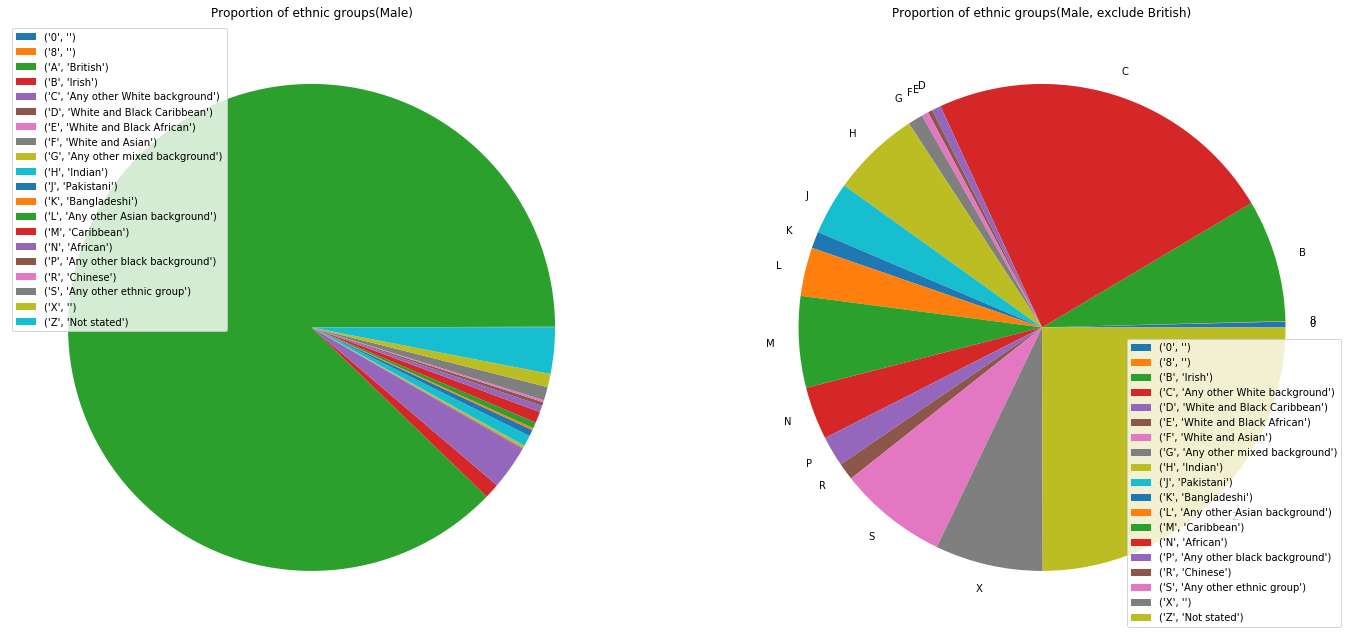

In [14]:
# Visualise the proportion in two pie charts
fig1, ax1 = plt.subplots(1, 2, figsize=(24, 24))
ax1[0].pie(m_ethnicity, textprops={'fontsize': 8})
ax1[1].pie(m_non_british, labels= [x[0] for x in m_non_british_labels])
ax1[0].set_title('Proportion of ethnic groups(Male)')
ax1[1].set_title('Proportion of ethnic groups(Male, exclude British)')
ax1[0].legend(m_labels)
ax1[1].legend(m_non_british_labels)

plt.show()

In [15]:
# The proportion of ethnic groups among female patients
fm_ethnicity = group_a['PATIENTID'][20:40]
fm_ethnicity_codes = [x[1] for x in fm_ethnicity.index]
fm_labels = list(zip(fm_ethnicity_codes, ethnicity_names))

# The proportion of ethnic groups among non-british female patients
fm_non_british = fm_ethnicity.drop(labels=(2, 'A'))
fm_non_british_labels = list(zip(fm_ethnicity_codes, ethnicity_names))
fm_non_british_labels.remove(('A', 'British'))

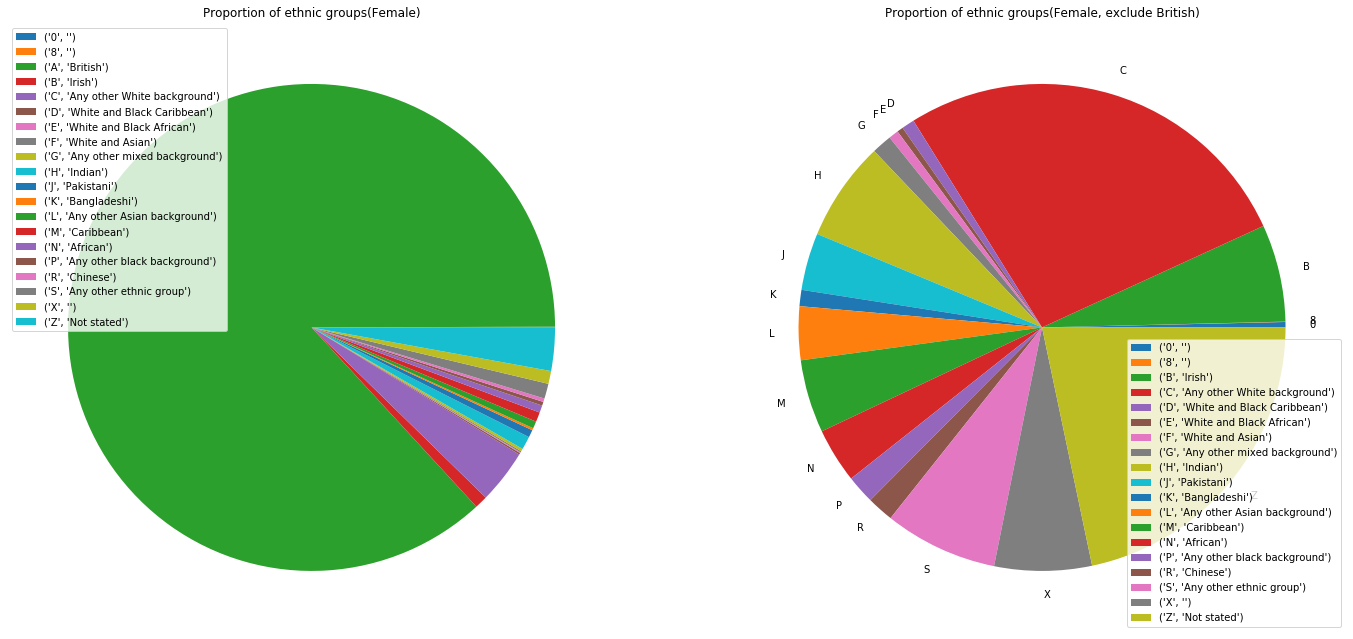

In [16]:
# Visualise the proportion in two pie charts
fig2, ax2 = plt.subplots(1, 2, figsize=(24, 24))
ax2[0].pie(fm_ethnicity)
ax2[1].pie(fm_non_british, labels=[x[0] for x in fm_non_british_labels])
ax2[0].set_title('Proportion of ethnic groups(Female)')
ax2[1].set_title('Proportion of ethnic groups(Female, exclude British)')
ax2[0].legend(fm_labels)
ax2[1].legend(fm_non_british_labels)

plt.show()

In [17]:
group_b = patient.groupby('DEATHCAUSECODE_1A').count()
# group_b
# group_b['PATIENTID'].plot()

In [18]:
patient['DEATHLOCATIONCODE'].value_counts().sum()

330380

## Death Location

In [21]:
patient['DEATHLOCATIONCODE'].value_counts()

1    138327
4     98681
2     40284
X     28209
5     17024
6      7146
3       709
Name: DEATHLOCATIONCODE, dtype: int64

## Death Causes

142,407 patients died because of bronchus or lung 

In [19]:
death_causes_1a = pd.Series(death_cause_1a_num)

print(death_causes_1a.idxmax(), death_causes_1a.max())
print(death_causes_1a.idxmin(), death_causes_1a.min())

C349 142407
G904 1


## Reference
[Ethnicity Category Code](https://www.datadictionary.nhs.uk/data_dictionary/attributes/e/end/ethnic_category_code_de.asp)

In [ ]:
# patient['VITALSTATUSDATE'] = pd.to_datetime(patient['VITALSTATUSDATE'])

# patient[patient['VITALSTATUSDATE']<pd.Timestamp('2000-01-01 00:00:00')]

# clean_data = patient.drop(patient[patient['VITALSTATUSDATE'] == '1900-01-01'].index)
# sns.scatterplot(x=clean_data['VITALSTATUSDATE'], y=clean_data['VITALSTATUSDATE'])
# patient['VITALSTATUSDATE'][0]
# plt.show()